In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
merged_df = pd.read_csv("Data/final_modeling_dataset.csv")
merged_df.head()

,periodname,week_start,week_end,Combined_positive,temp_c,rh_pct,rain_mm,wind10_kmh,soil_moisture_top_m3m3
0,Week 1 2018-12-31 - 2019-01-06,2018-12-31,2019-01-06,66.0,30.115476,38.166667,0.0,20.397024,0.027899
1,Week 2 2019-01-07 - 2019-01-13,2019-01-07,2019-01-13,110.0,30.488690,24.785714,0.0,20.902381,0.025518
2,Week 3 2019-01-14 - 2019-01-20,2019-01-14,2019-01-20,73.0,30.727381,31.047619,0.0,15.034524,0.021024
3,Week 4 2019-01-21 - 2019-01-27,2019-01-21,2019-01-27,70.0,31.342857,28.553571,0.0,19.123810,0.019250
4,Week 5 2019-01-28 - 2019-02-03,2019-01-28,2019-02-03,48.0,31.215476,28.142857,0.0,21.282738,0.021952


In [3]:
merged_df.columns

Index(['periodname', 'week_start', 'week_end', 'Combined_positive', 'temp_c',
       'rh_pct', 'rain_mm', 'wind10_kmh', 'soil_moisture_top_m3m3'],
      dtype='object')

## Modelling

### 1. Imports & Config

In [4]:
# libraries
import numpy as np
import pandas as pd
from math import ceil
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# CONFIG
# -----------------------------
TARGET = "Combined_positive"
EXOG_LAGS = {
    "temp_c": 4,
    "rh_pct": 4,
    "rain_mm": 4,
    "wind10_kmh": 4,
    "soil_moisture_top_m3m3": 4,
}
TARGET_LAGS = [1, 2, 3, 4]    # autoregressive terms
MIN_TEST_WEEKS = 12
RANDOM_STATE = 42

### 2. Data Preparation & Feature Engineering

In [5]:
# Keep only relevant columns
cols = ["week_start", TARGET, "temp_c", "rh_pct", "rain_mm", "wind10_kmh", "soil_moisture_top_m3m3"]
df = (merged_df[cols]
      .assign(week_start=lambda d: pd.to_datetime(d["week_start"]))
      .sort_values("week_start")
      .set_index("week_start"))

# Build supervised dataset
def build_supervised(df, target, exog_lags_dict, target_lags):
    out = df.copy()
    # exogenous lags
    for var, L in exog_lags_dict.items():
        out[f"{var}_lag{L}"] = out[var].shift(L)
    # target lags
    for L in target_lags:
        out[f"{target}_lag{L}"] = out[target].shift(L)

    out = out.dropna()
    feature_cols = [f"{v}_lag{L}" for v, L in exog_lags_dict.items()] + [f"{target}_lag{L}" for L in target_lags]
    X = out[feature_cols]
    y = out[target]
    return out, X, y, feature_cols

df_sup, X, y, feature_cols = build_supervised(df, TARGET, EXOG_LAGS, TARGET_LAGS)

### 3. Train/Test Split

In [6]:
# Chronological split (no shuffle)
test_weeks = max(MIN_TEST_WEEKS, ceil(len(df_sup) * 0.2))
X_train, X_test = X.iloc[:-test_weeks], X.iloc[-test_weeks:]
y_train, y_test = y.iloc[:-test_weeks], y.iloc[-test_weeks:]

### 4. Metrics Helper Functions

In [7]:
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "MAPE%": mape, "sMAPE%": smape}

def show_metrics(name, d):
    print(f"{name}: " + ", ".join([f"{k}={v:.3f}" for k, v in d.items()]))

### 5. Baseline Models

In [8]:
# Naïve persistence
y_pred_naive = y.shift(1).loc[y_test.index]
baseline_naive = metrics(y_test, y_pred_naive)

# Random Forest (baseline, default params)
rf_base = RandomForestRegressor(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1)
rf_base.fit(X_train, y_train)
pred_base = rf_base.predict(X_test)
baseline_rf = metrics(y_test, pred_base)

### 6. Tuned Random Forest

In [9]:
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    "n_estimators": [400, 600, 800],
    "max_depth": [None, 6, 10, 14],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", 0.7, 0.9],
}
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
gcv = GridSearchCV(rf, param_grid, cv=tscv, scoring="neg_mean_absolute_error", n_jobs=-1, refit=True)
gcv.fit(X_train, y_train)

best_rf = gcv.best_estimator_
pred_tuned = best_rf.predict(X_test)
tuned_metrics = metrics(y_test, pred_tuned)

print("=== Test-set metrics ===")
show_metrics("Naïve (t-1)", baseline_naive)
show_metrics("RF baseline", baseline_rf)
show_metrics("RF tuned  ", tuned_metrics)
print("\nBest params:", gcv.best_params_)

=== Test-set metrics ===
Naïve (t-1): MAE=842.101, RMSE=1151.140, R2=0.644, MAPE%=39.578, sMAPE%=34.412
RF baseline: MAE=767.823, RMSE=1065.782, R2=0.695, MAPE%=38.076, sMAPE%=30.736
RF tuned  : MAE=751.270, RMSE=1050.905, R2=0.703, MAPE%=37.648, sMAPE%=30.470

Best params: {'max_depth': 6, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}


### 7. Forecasting 5 Weeks Ahead

In [10]:
df.index[:10]

DatetimeIndex(['2018-12-31', '2019-01-07', '2019-01-14', '2019-01-21',
               '2019-01-28', '2019-02-04', '2019-02-11', '2019-02-18',
               '2019-02-25', '2019-03-04'],
              dtype='datetime64[ns]', name='week_start', freq=None)

In [11]:
df.index[-10:]

DatetimeIndex(['2025-06-30', '2025-07-07', '2025-07-14', '2025-07-21',
               '2025-07-28', '2025-08-04', '2025-08-11', '2025-08-18',
               '2025-08-25', '2025-09-01'],
              dtype='datetime64[ns]', name='week_start', freq=None)

In [13]:
def forecast_n_steps(df_raw, model, steps, exog_lags_dict, target_lags, feature_cols, target_col):
    # ⬇️ ADD THIS GUARD
    max_h = min(exog_lags_dict.values())
    if steps > max_h:
        raise ValueError(
            f"steps={steps} exceeds allowed horizon ({max_h}) given the smallest exogenous lag; "
            "reduce steps or increase that lag."
        )
    # existing code continues...
    
    last_date = df_raw.index.max()
    preds, dates = [], []
    y_lag_vals = [df_raw[target_col].iloc[-i] for i in range(1, max(target_lags) + 1)]

    for h in range(1, steps + 1):
        date_h = last_date + pd.Timedelta(weeks=h)
        feat = {}
        for var, L in exog_lags_dict.items():
            feat[f"{var}_lag{L}"] = df_raw[var].loc[date_h - pd.Timedelta(weeks=L)]
        for L in target_lags:
            feat[f"{target_col}_lag{L}"] = y_lag_vals[L - 1]
        X_new = pd.DataFrame([feat], index=[date_h])[feature_cols]
        yhat = float(model.predict(X_new))
        preds.append(yhat)
        dates.append(date_h)
        y_lag_vals = [yhat] + y_lag_vals[:-1]

    return pd.Series(preds, index=dates, name="prediction")

allowed_h = min(EXOG_LAGS.values())  # smallest exog lag (currently 4)
steps = min(5, allowed_h)            # -> 4

pred_5w = forecast_n_steps(df, best_rf, steps=steps,
                           exog_lags_dict=EXOG_LAGS,
                           target_lags=TARGET_LAGS,
                           feature_cols=feature_cols,
                           target_col=TARGET)

### 8. Outbreak Detection

In [14]:
last_actual = df[TARGET].iloc[-1]
ratios = pred_5w.copy().astype(float)

# Compare first forecast to last observed
ratios.iloc[0] = pred_5w.iloc[0] / (last_actual if last_actual != 0 else 1e-8)

# Subsequent weeks vs previous prediction
for i in range(1, len(pred_5w)):
    denom = pred_5w.iloc[i-1] if pred_5w.iloc[i-1] != 0 else 1e-8
    ratios.iloc[i] = pred_5w.iloc[i] / denom

outbreak_flag = np.where(ratios > 1.5, "Outbreak", "No")

pred_table = pd.DataFrame({
    "prediction": pred_5w,
    "ratio_vs_prev": ratios,
    "outbreak_flag": outbreak_flag
})

print("\n=== 5-week forecast & outbreak flag ===")
print(pred_table)


=== 5-week forecast & outbreak flag ===
             prediction  ratio_vs_prev outbreak_flag
2025-09-08  3615.094115       1.302267            No
2025-09-15  5018.975842       1.388339            No
2025-09-22  5059.490887       1.008072            No
2025-09-29  5358.968231       1.059191            No


### 9. Plot: Actual vs Predicted (test set)

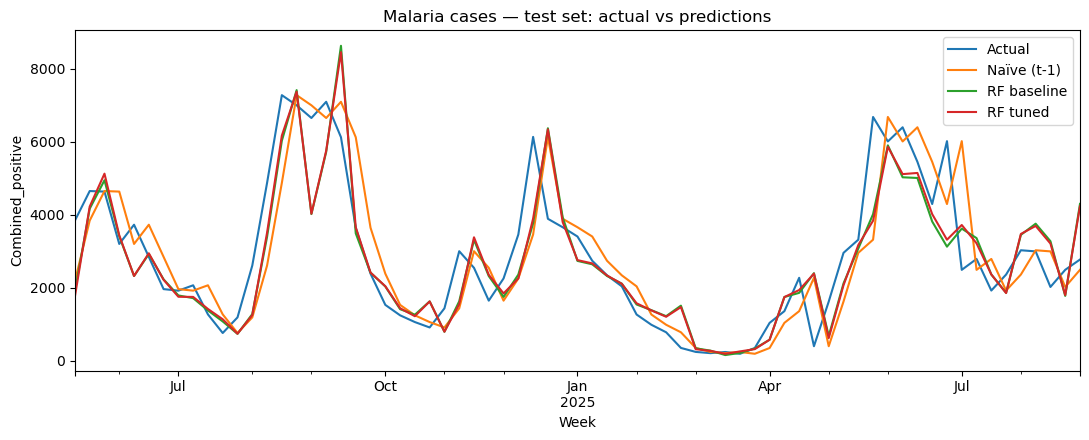

In [15]:
import matplotlib.pyplot as plt

# Align into a single DataFrame for plotting
plot_df = pd.DataFrame({
    "Actual": y_test,
    "Naive": y_pred_naive,
    "RF_baseline": pred_base,
    "RF_tuned": pred_tuned
})

plt.figure(figsize=(11,4.5))
plot_df["Actual"].plot(label="Actual")
plot_df["Naive"].plot(label="Naïve (t-1)")
plot_df["RF_baseline"].plot(label="RF baseline")
plot_df["RF_tuned"].plot(label="RF tuned")
plt.title("Malaria cases — test set: actual vs predictions")
plt.xlabel("Week")
plt.ylabel("Combined_positive")
plt.legend()
plt.tight_layout()
plt.show()

### 10. Plot: Residuals (tuned model on test set)

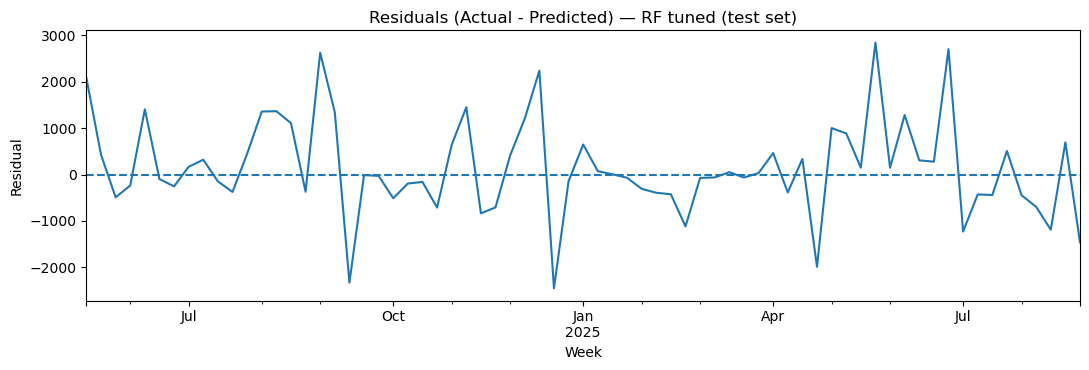

In [16]:
resid = y_test - pred_tuned

plt.figure(figsize=(11,3.8))
resid.plot()
plt.axhline(0, linestyle="--")
plt.title("Residuals (Actual - Predicted) — RF tuned (test set)")
plt.xlabel("Week")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

### 11. Plot: Feature Importances (tuned RF)

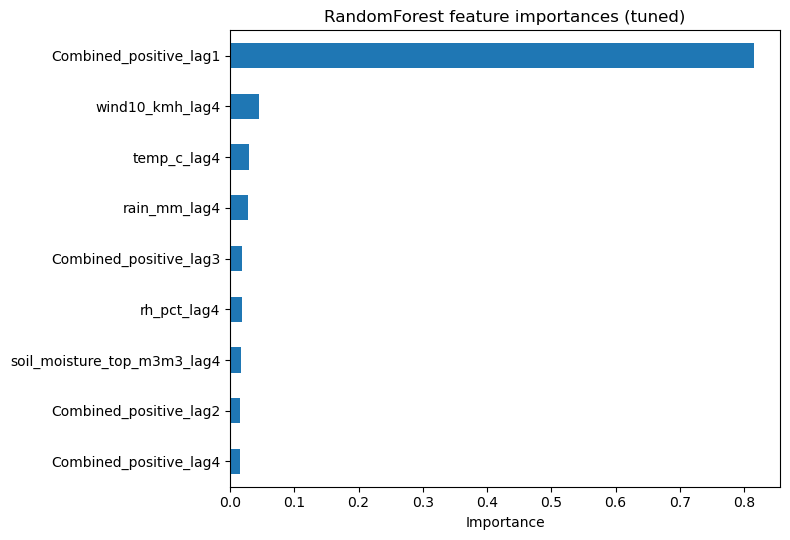

In [17]:
imp = pd.Series(best_rf.feature_importances_, index=feature_cols).sort_values(ascending=True)

plt.figure(figsize=(8,5.5))
imp.plot(kind="barh")
plt.title("RandomForest feature importances (tuned)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### 12. Plot: 5-Week Forecast with Outbreak Flags

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>)

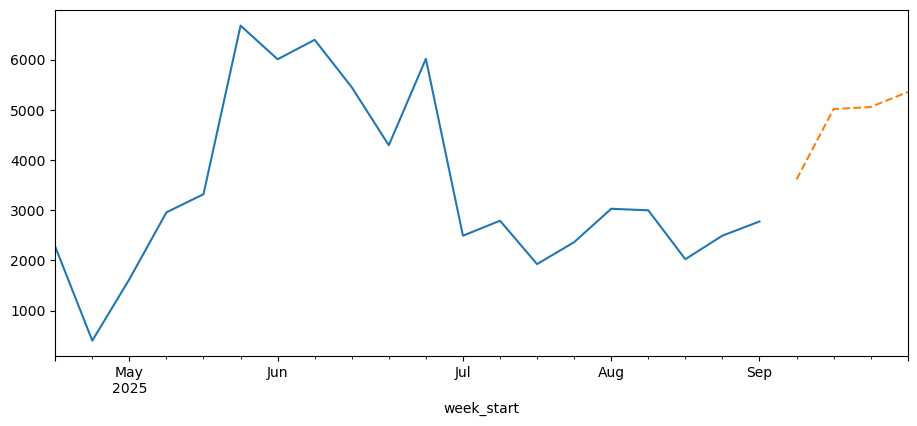

In [18]:
# Combine last 20 weeks of actuals with the 5-week forecast for context
history_weeks = 20
hist = df[TARGET].iloc[-history_weeks:]
forecast = pred_5w

plt.figure(figsize=(11,4.5))
hist.plot(label="Actual (recent)")
forecast.plot(style="--", label="Forecast (5w)")

# mark outbreak weeks
outbreak_idx = pred_table.index[pred_table["outbreak_flag"] == "Outbreak"]
outbreak_vals = pred_table.loc[outbreak_idx, "prediction"]
plt.scatter(outbreak_idx, outbreak_vals, marker="o", s=60, label="Outbreak flag")

plt.title("5-week malaria forecast with outbreak flags")
plt.xlabel("Week")
plt.ylabel("Combined_positive")
plt.legend()
plt.tight_layout()
plt.show()

### 13. Error Distribution Plot (tuned model)

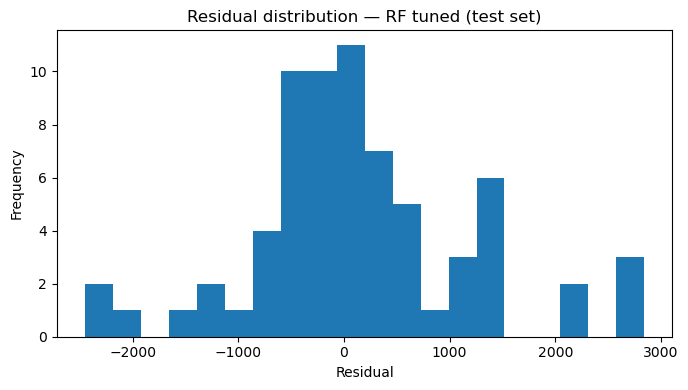

In [19]:
plt.figure(figsize=(7,4))
plt.hist(resid, bins=20)
plt.title("Residual distribution — RF tuned (test set)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### 14. For Visualization

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>)

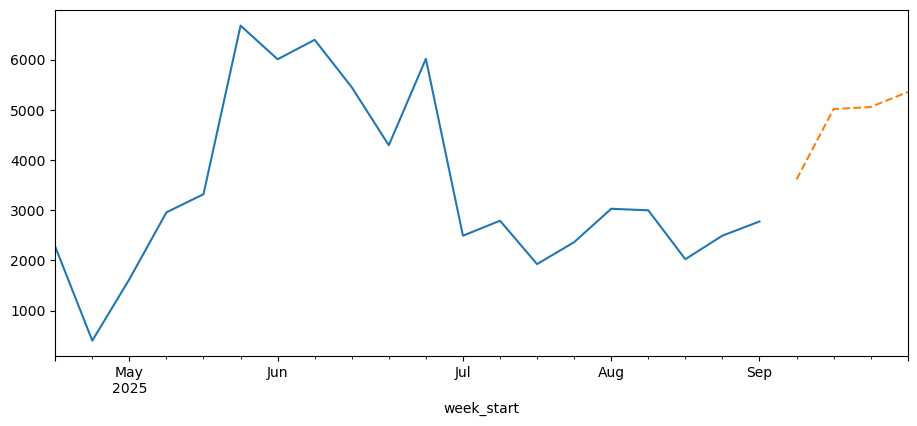

In [20]:
# Repeat the plotting code above but replace the final show() with savefig(...)
# Example for the forecast plot:
plt.figure(figsize=(11,4.5))
hist.plot(label="Actual (recent)")
forecast.plot(style="--", label="Forecast (5w)")
plt.scatter(outbreak_idx, outbreak_vals, marker="o", s=60, label="Outbreak flag")
plt.title("5-week malaria forecast with outbreak flags")
plt.xlabel("Week")
plt.ylabel("Combined_positive")
plt.legend()
plt.tight_layout()
plt.savefig("forecast_outbreak_flags.png", dpi=200)
plt.close()

**Note:**   
Those Combined_positive_lag1..4 columns are past values of the target used as predictors. Random Forest itself isn’t time-aware, so we give it history of the target to capture autocorrelation—this is the classic AR/ARX idea. That’s also why your feature-importance plot shows Combined_positive_lag1 dominating: malaria cases are persistent week to week.  
**Why it’s useful** 
* Improves accuracy by letting the model learn temporal dependence.  
* Enables iterative multi-step forecasts: you predict week t+1, then feed that back as lag1 to predict t+2, etc.

**When you might not want it**  
* If you want a purely exogenous model (only weather/soil inputs).  
* If you’ll provide future exogenous values and don’t want recursive forecastin
